In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Loading development set 

In [2]:
images = 'Manually_Annotated_file_lists/'
filename = 'validation.csv'
names_list = ['subDirectory_filePath','face_x','face_y','face_width','face_height','facial_landmarks','expression','valence','arousal']

df_valid = pd.read_csv(images + filename, names = names_list)

df_valid_need = df_valid[~df_valid.expression.isin([7,8,9,10])] 
df_valid_need = df_valid_need.reset_index(drop=True)

dict_name_labels = {0: 'Neutral', 1: 'Happiness', 2: 'Sadness', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger'}
labels_valid = ['{}_{}'.format(i,dict_name_labels[i])for i in df_valid_need.expression]
df_valid_need.expression = labels_valid

In [3]:
images = 'D:/Databases/AffectNet_short_set/'

batch_size = 64
height_width = 224

def preproc(x):
    x = utils.preprocess_input(x, version = 2)
    return x

datagen_valid = ImageDataGenerator(preprocessing_function=preproc)

validation_generator = datagen_valid.flow_from_dataframe(df_valid_need,
                                                       directory=images,
                                                       x_col='subDirectory_filePath',
                                                       y_col='expression',
                                                       target_size=(height_width, height_width),
                                                       class_mode="categorical",
                                                       batch_size=batch_size,
                                                       shuffle=False)

Found 3500 validated image filenames belonging to 7 classes.


Building the model

In [4]:
def network(model='resnet50', input_shape=(224, 224, 3), path_weight_model = ''):
    
    resnet50_features = VGGFace(model=model, include_top=False, input_shape=input_shape, pooling=None)
    
    gaus = tf.keras.layers.GaussianNoise(0.1)(resnet50_features.output)
    x = tf.keras.layers.Dense(units=512, kernel_regularizer=keras.regularizers.l2(1e-4), activation = 'relu')(gaus)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(7, activation = 'softmax')(x) 
    model_resnet50_features = tf.keras.models.Model(resnet50_features.input, x)
    model_resnet50_features.load_weights(path_weight_model)
    
    return model_resnet50_features

Getting class probabilities and prediction

In [5]:
model = network(path_weight_model='models/EmoAffectnet/weights_66_37.h5')
val_predict=model.predict(validation_generator, verbose=1)
val_predict = val_predict.reshape(-1,7)
val_predict=np.argmax(val_predict,axis=1)
val_targ = validation_generator.labels

55/55 [==============================] - 62s 876ms/step


Drawing the confusion matrix

In [6]:
def draw_conf_matrix_clas_report(y_true, y_pred, name_labels='', name_model=''):

    c_m = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(c_m, name_labels, name_labels)

    plt.figure(figsize = (9,9))

    group_counts = ['{0:0.0f}'.format(value) for value in
                  conf_matrix.values.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in
                        conf_matrix.div(np.sum(conf_matrix, axis=1), axis=0).values.flatten()]

    labels = ['{}\n{}'.format(v1,v2) for v1,v2 in zip(group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(c_m.shape)
    sns.set(font_scale=1.8)
    chart = sns.heatmap(conf_matrix,
              cbar=False ,
              annot=labels,
              square=True,
              fmt='',
              annot_kws={ 'size': 18},
              cmap="Blues",
              )
    chart.set_xticklabels(name_labels)
    chart.set_yticklabels(name_labels, rotation=360, verticalalignment='center')
    plt.savefig('confusion_matrix_{}.png'.format(name_model), bbox_inches='tight', pad_inches=0)

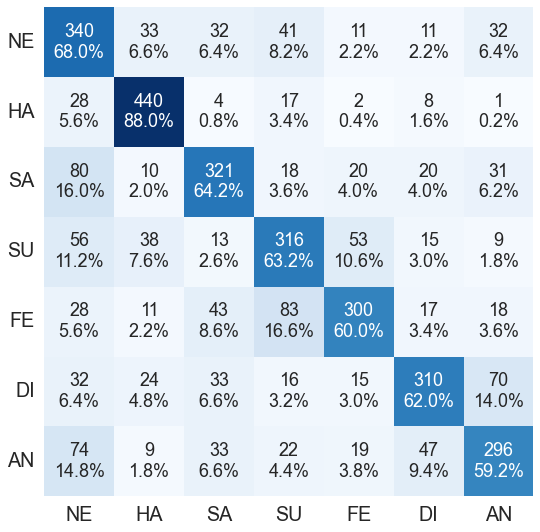

In [7]:
name_labels = ['NE', 'HA', 'SA', 'SU', 'FE', 'DI', 'AN']
draw_conf_matrix_clas_report(val_targ, val_predict, name_labels, 'AffectNet_valid_2')

In [8]:
print(classification_report(val_targ, val_predict, target_names=name_labels, digits=3))

              precision    recall  f1-score   support

          NE      0.533     0.680     0.598       500
          HA      0.779     0.880     0.826       500
          SA      0.670     0.642     0.656       500
          SU      0.616     0.632     0.624       500
          FE      0.714     0.600     0.652       500
          DI      0.724     0.620     0.668       500
          AN      0.648     0.592     0.619       500

    accuracy                          0.664      3500
   macro avg      0.669     0.664     0.663      3500
weighted avg      0.669     0.664     0.663      3500

